## Part 2 - Clustering

Importing the required libraries and checking for the python version.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import cv2

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Loading only the training dataset for Part 2 of the coursework

In [2]:
CW_DATASET_PATH = "CW_dataset"

def load_train_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)

    return x_train_all, y_train_all

In [3]:
x_train, y_train = load_train_data()

In [4]:
x_train.shape

(9690, 2304)

In [5]:
y_train.shape

(9690, 1)

### 1) K-means Clustering

Plotted the clusters for the train dataset by using a dimentionality reduction technique called PCA.

In [6]:
def plot_clusters(X, y = None):
    plt.scatter(X[:, 0], X[:, 1],c=y, s=3, alpha=0.7) #s is the size of dots.
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

In [7]:
def plot_figure(title, X, y = None):
    plt.figure(figsize=(8, 4))
    plt.title(title)
    plot_clusters(X, y)
    plt.show()

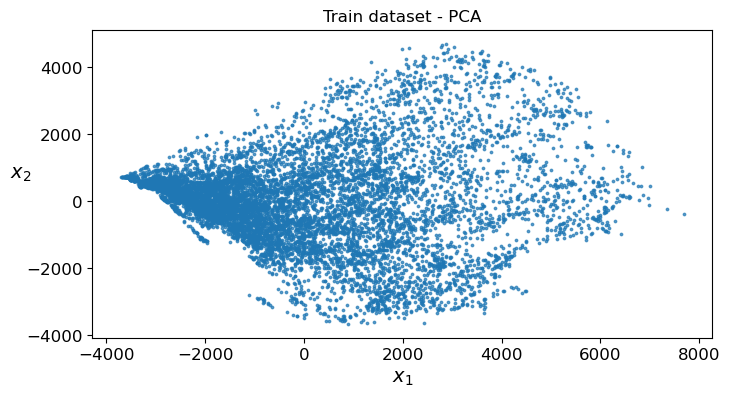

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca1 = pca.fit_transform(x_train, y_train)

plot_figure("Train dataset - PCA", X_pca1)

Preprocessed the train dataset by winsorizing and normalising the data.

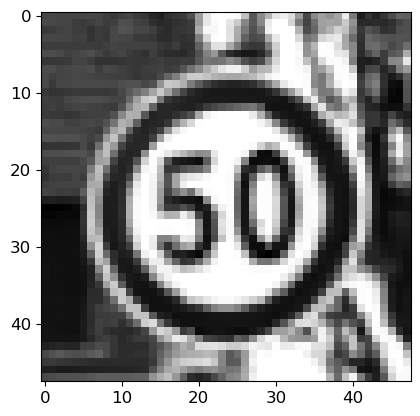

In [9]:
import matplotlib.pyplot as plt

img = x_train.iloc[4391]
img = img.values.reshape((48, 48))

plt.imshow(img, cmap='gray')
plt.show()

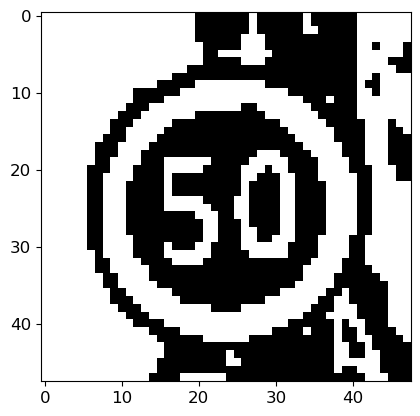

In [10]:
import cv2

ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh1,cmap='gray')

In [11]:
threshold_value = 120
threshold_img_xtrain = "thresholded_images"

In [12]:
# Create the output folder if it doesn't exist
if not os.path.exists(threshold_img_xtrain):
    os.makedirs(threshold_img_xtrain)

# Loop through the dataset and apply thresholding
for i in range(len(x_train)):
    img = x_train.iloc[i].values.reshape((48, 48))
    ret, thresh1 = cv2.threshold(img, threshold_value, 255, cv2.THRESH_BINARY_INV)
    output_path = os.path.join(threshold_img_xtrain, f"thresholded_{i}.png")
    cv2.imwrite(output_path, thresh1)

In [13]:
thresholded_images = []
for i in range(len(x_train)):
    img_path = os.path.join(threshold_img_xtrain, f"thresholded_{i}.png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    thresholded_images.append(img)

x_train = np.array(thresholded_images)

In [14]:
# smoothed_images = []
# for img in x_train:

#     smoothed = cv2.GaussianBlur(img, (5,5), 0)  # You can adjust the kernel size (e.g., (5, 5)) as needed
#     smoothed_images.append(smoothed)
   

# # Convert the list of smoothed images to a numpy array
# x_train = np.asarray(smoothed_images)

In [15]:
# x_train = np.asarray(x_train)

In [16]:
from scipy.stats.mstats import winsorize

# Winsorize the data (adjust percentiles as needed)
winsorized_data = winsorize(x_train, limits=[0.05, 0.05])

def normalise(images):
    preprocessed_images = []
    for image in images: 
        if(len(image.shape) == 3):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)

        adjusted = cv2.convertScaleAbs(image, alpha=0.5, beta = 10)
        enhanced_image = cv2.equalizeHist(adjusted)
        image = enhanced_image/255.0
        resize = cv2.resize(image, (48,48))

        preprocessed_images.append(resize)
    return  np.array(preprocessed_images)


x_train = normalise(x_train)

x_train = x_train.reshape(x_train.shape[0], -1)
x_train.shape

(9690, 2304)

In [17]:
#variance thresholdimg 

from sklearn.feature_selection import VarianceThreshold

# Set a threshold for variance (e.g., 0.1, but this value depends on your data)
threshold_value = 0.15

x_train = pd.DataFrame(x_train)
# Instantiate the VarianceThreshold object
selector = VarianceThreshold(threshold=threshold_value)

# Assuming 'df' is your dataset
# Fit the selector to the data
selector.fit(x_train)

# Get the indices of features to keep
features_to_keep = selector.get_support(indices=True)

# Create a new DataFrame with selected features
df_high_variance = x_train.iloc[:, features_to_keep]


x_train = np.asarray(df_high_variance)

In [18]:
features_to_keep

array([   0,    1,    2, ..., 2292, 2293, 2294])

Plotted the clusters again using PCA and also plotted the clusters using t-SNE for exploration.

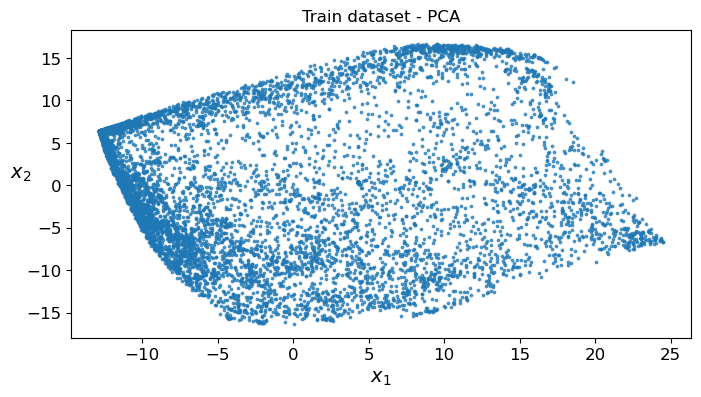

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca2 = pca.fit_transform(x_train, y_train)

plot_figure("Train dataset - PCA", X_pca2)

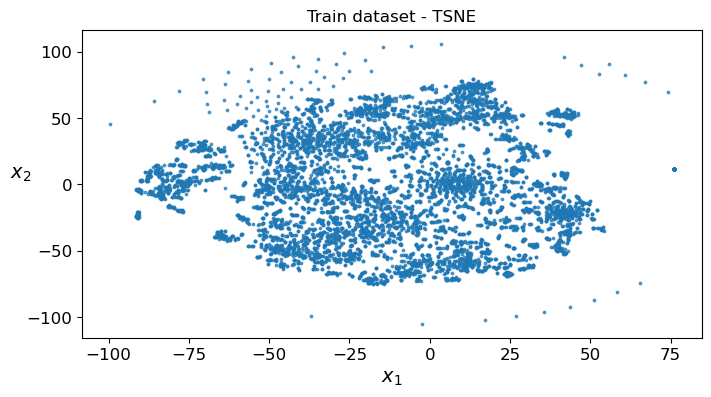

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train)

plot_figure("Train dataset - TSNE", x_train_tsne)

Applied K-Means clusterer on the dataset and received the silhouette score. Used k = 10 at the start, i.e., 10 clusters.

In [21]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_train_scaled)

k = 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

In [22]:
tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train)

kmeans_tsne = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels_tsne = kmeans_tsne.fit_predict(x_train_tsne)

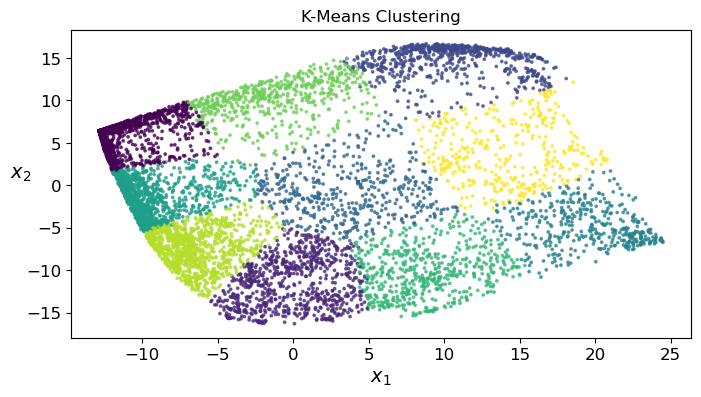

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca3 = pca.fit_transform(x_train)

plot_figure("K-Means Clustering", X_pca3, cluster_labels)

In [24]:
from sklearn.metrics import accuracy_score

def accuracy(c_labels, X, y_train, k, model):
    y_train = np.asarray(y_train)
    cl = model.fit_predict(X)

    for i in range(k):
        c = {}
        for j in range(len(c_labels)):
            if i == c_labels[j]:
                ground_truth_label = int(y_train[j])
                if ground_truth_label in c:
                    c[ground_truth_label] += 1
                else:
                    c[ground_truth_label] = 1
        max_c = max(c, key=c.get)
        for l in range(len(c_labels)):
            if i == c_labels[l]:
                cl[l] = max_c

    accuracy = accuracy_score(y_train, cl)  # Compare with ground truth labels
    print(f"Clustering Accuracy: {accuracy}")
    return accuracy

In [25]:
a1 = accuracy(cluster_labels, X_pca, y_train, k, kmeans)

Clustering Accuracy: 0.3153766769865841


In [26]:
a2 = accuracy(cluster_labels_tsne, x_train_tsne, y_train, k, kmeans_tsne)

Clustering Accuracy: 0.3826625386996904


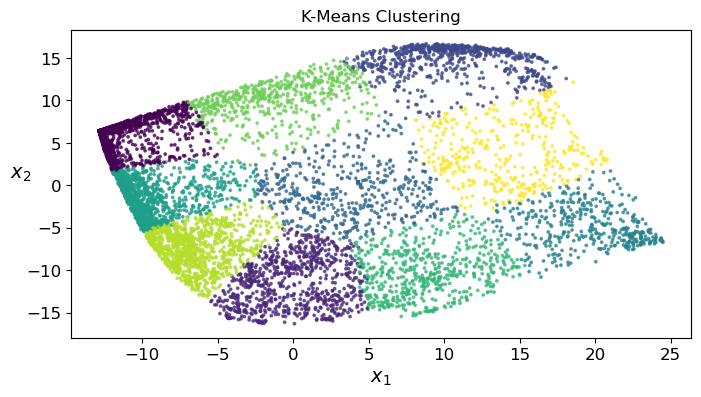

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca3 = pca.fit_transform(x_train)

plot_figure("K-Means Clustering", X_pca3, cluster_labels)

In [28]:
cluster_labels

array([3, 3, 3, ..., 7, 7, 7], dtype=int32)

In [29]:
cluster_labels is kmeans.labels_

False

In [30]:
kmeans.inertia_

514304.324571463

In [31]:
kmeans.cluster_centers_

array([[-2.67411456e+01,  1.38589970e+01],
       [-1.68671109e+00, -2.68776025e+01],
       [ 2.65605990e+01,  3.35155856e+01],
       [ 1.02837954e+01,  1.35115600e-02],
       [ 4.72576418e+01, -1.26538895e+01],
       [-2.32039116e+01, -2.43742894e+00],
       [ 2.03835488e+01, -2.45183221e+01],
       [-2.06839860e+00,  2.35059887e+01],
       [-1.68009739e+01, -1.64457663e+01],
       [ 3.46608469e+01,  8.57056614e+00]])

In [32]:
kmeans.labels_

array([4, 4, 4, ..., 3, 3, 3], dtype=int32)

In [33]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(X_pca, cluster_labels)
print("Silhouette Score = ", silhouette_scores)

Silhouette Score =  0.5419757312839785


In [34]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(x_train_tsne, cluster_labels_tsne)
print("Silhouette Score = ", silhouette_scores)

Silhouette Score =  0.5261659


In [35]:
# Reference : https://colab.research.google.com/drive/1wq7JGYCT6Ctgd572KN9_QuIJwCS9tNo5?usp=sharing#scrollTo=7ZtUIKwNEcFS
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

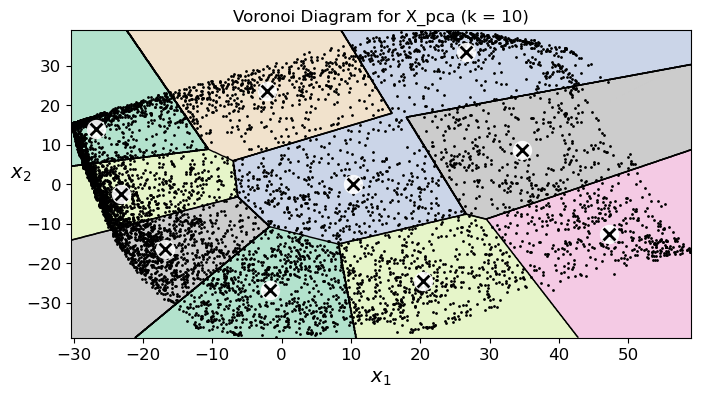

In [36]:
plt.figure(figsize=(8, 4))
plt.title("Voronoi Diagram for X_pca (k = 10)")
plot_decision_boundaries(kmeans, X_pca)
plt.show()

### 2) Hard & Soft Clustering

### 3) Determining Optimal Number of Clusters

In [37]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

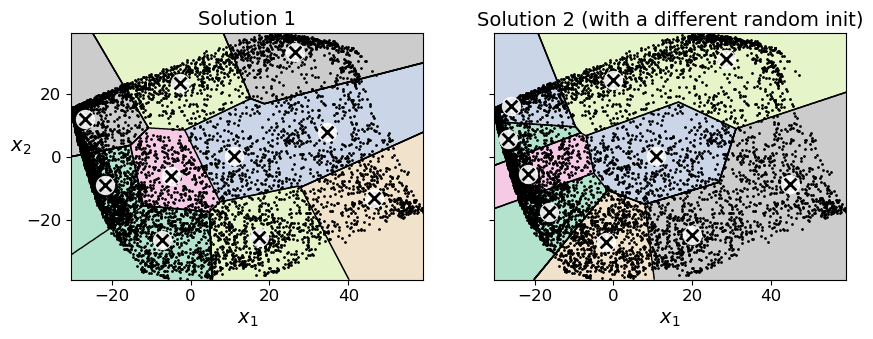

In [38]:
kmeans_rnd_init1 = KMeans(n_clusters=10, init="random", n_init=1,
                         algorithm="lloyd", random_state=44)
kmeans_rnd_init2 = KMeans(n_clusters=10, init="random", n_init=1,
                         algorithm="lloyd", random_state=50)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X_pca,
                          "Solution 1", "Solution 2 (with a different random init)")
plt.show()

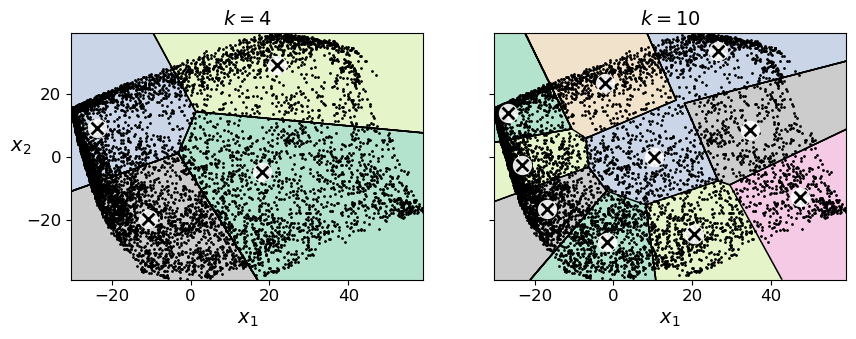

In [39]:
kmeans_k4 = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_k10 = KMeans(n_clusters=10, random_state=42, n_init=10)

plot_clusterer_comparison(kmeans_k4, kmeans_k10, X_pca, "$k=4$", "$k=10$")
plt.show()

In [40]:
max_cluster=13
kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_pca)
                for k in range(1, max_cluster)]
inertias = [model.inertia_ for model in kmeans_per_k]

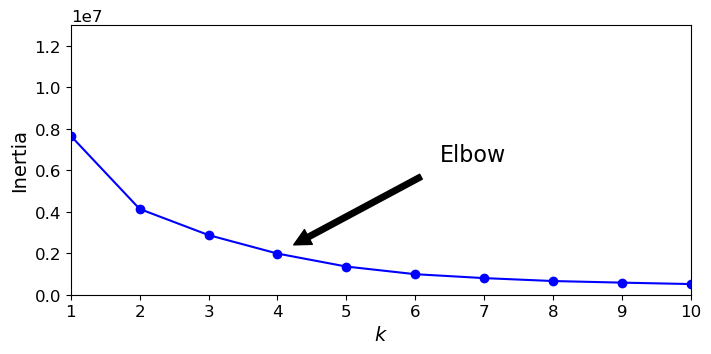

In [41]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, max_cluster), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 10, 0, 13000000])  # Adjust the y-axis limit as needed
plt.show()


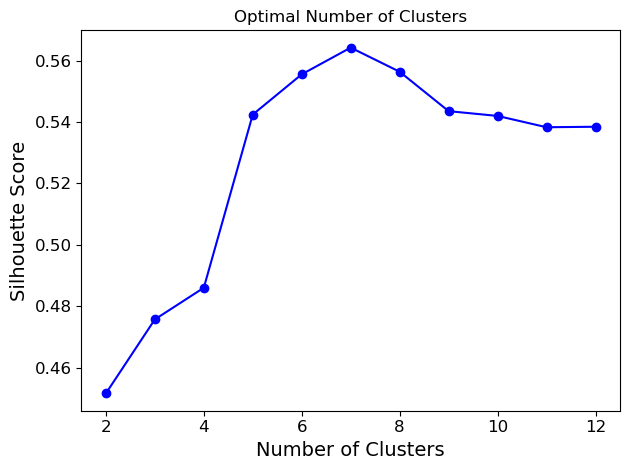

In [42]:
silhouette_scores = [silhouette_score(X_pca, model.labels_) for model in kmeans_per_k[1:]]     

plt.plot(range(2, max_cluster), silhouette_scores, "bo-")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Optimal Number of Clusters")
plt.tight_layout()
plt.show()

# Hierarchical Clustering

### PCA

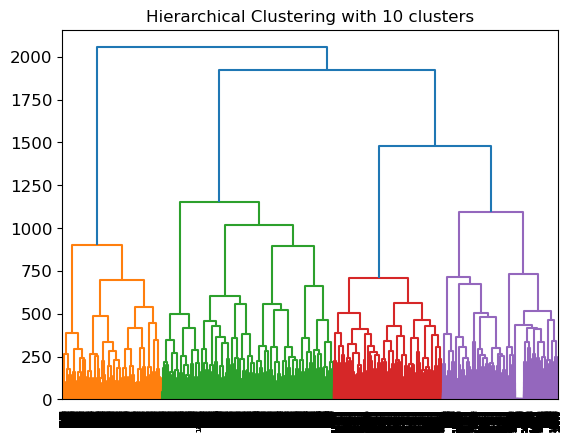

In [27]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

n_clusters=10
agg_clustering = AgglomerativeClustering(n_clusters=10)
agg_labels = agg_clustering.fit_predict(X_pca)

linkage_matrix = linkage(X_pca, method='ward')

dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering with 10 clusters')
plt.show()

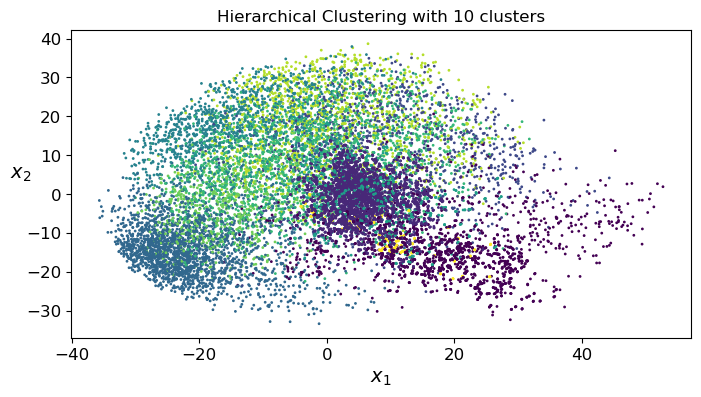

In [28]:
plt.figure(figsize=(8, 4))
plt.title("Hierarchical Clustering with 10 clusters")
plot_clusters(X_pca, agg_labels)
plt.show()

In [29]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(X_pca, agg_labels)
print("Silhouette Score = ", silhouette_scores)

Silhouette Score =  0.06651732221754462


Silhouette Score with t-SNE + K-Means =  0.31194657


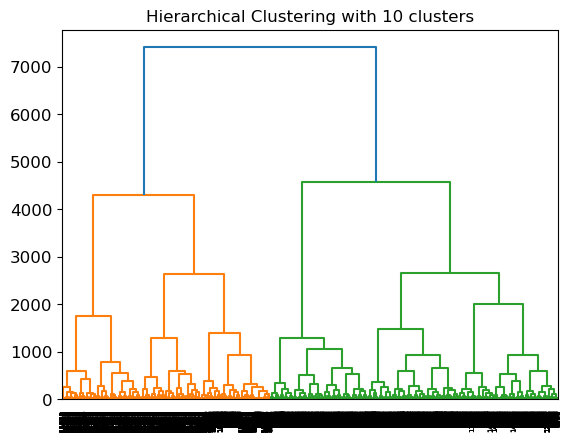

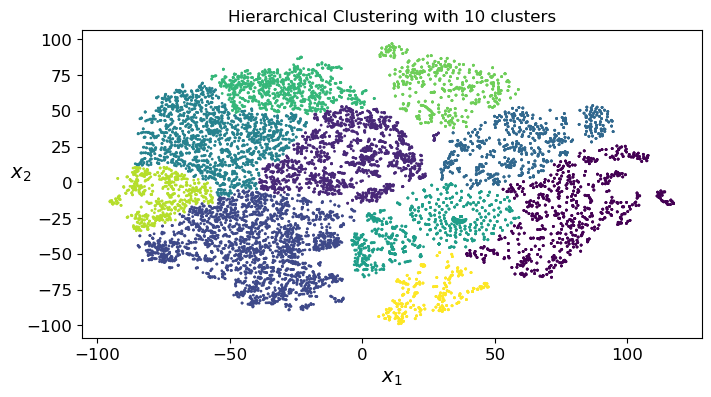

In [30]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train_scaled)


agg_clustering_tsne = AgglomerativeClustering(n_clusters=10)
agg_labels_tsne = agg_clustering_tsne.fit_predict(x_train_tsne)

silhouette_scores_tsne = silhouette_score(x_train_tsne, agg_labels_tsne)
print("Silhouette Score with t-SNE + K-Means = ", silhouette_scores_tsne)

linkage_matrix = linkage(x_train_tsne, method='ward')

dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering with 10 clusters')
plt.show()

plt.figure(figsize=(8, 4))
plt.title("Hierarchical Clustering with 10 clusters")
plot_clusters(x_train_tsne, agg_labels_tsne)
plt.show()

# Hierarchical with 2 clusters

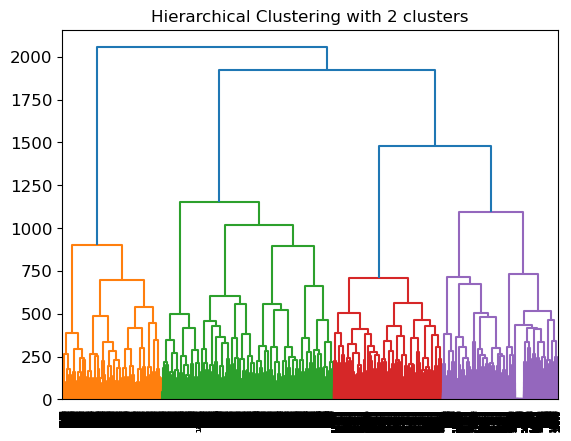

In [31]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

n_clusters=10
agg_clustering_2 = AgglomerativeClustering(n_clusters=2)
agg_labels_2 = agg_clustering_2.fit_predict(X_pca)

linkage_matrix_2 = linkage(X_pca, method='ward')

dendrogram(linkage_matrix_2)
plt.title('Hierarchical Clustering with 2 clusters')
plt.show()

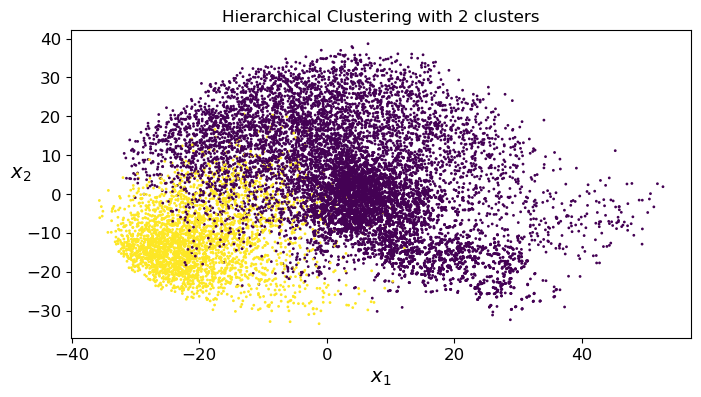

In [32]:
plt.figure(figsize=(8, 4))
plt.title("Hierarchical Clustering with 2 clusters")
plot_clusters(X_pca, agg_labels_2)
plt.show()

In [33]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(X_pca, agg_labels_2)
print("Silhouette Score = ", silhouette_scores)

Silhouette Score =  0.062241071255935615


Silhouette Score with t-SNE + Heirarchy =  0.37441516


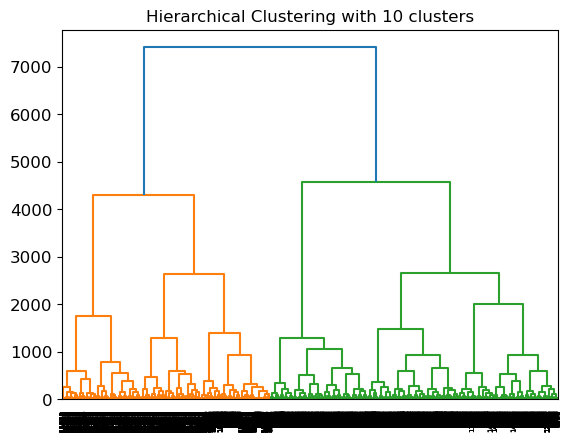

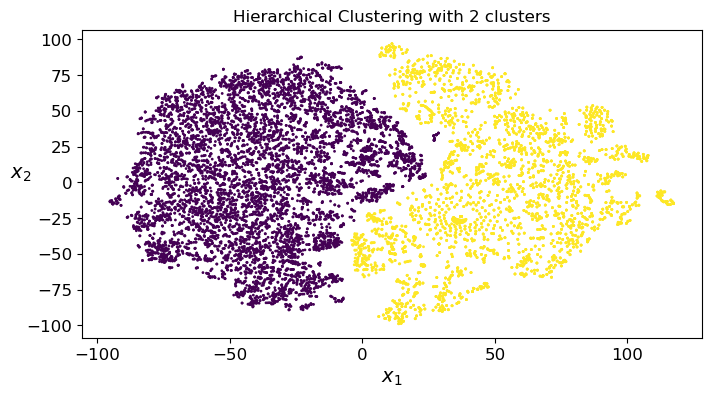

In [34]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train_scaled)

# Now apply K-means clustering on the t-SNE processed data
agg_clustering_tsne = AgglomerativeClustering(n_clusters=2)
agg_labels_tsne = agg_clustering_tsne.fit_predict(x_train_tsne)

silhouette_scores_tsne = silhouette_score(x_train_tsne, agg_labels_tsne)
print("Silhouette Score with t-SNE + Heirarchy = ", silhouette_scores_tsne)

linkage_matrix = linkage(x_train_tsne, method='ward')

dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering with 10 clusters')
plt.show()

plt.figure(figsize=(8, 4))
plt.title("Hierarchical Clustering with 2 clusters")
plot_clusters(x_train_tsne, agg_labels_tsne)
plt.show()

# Gaussian Mixture Models

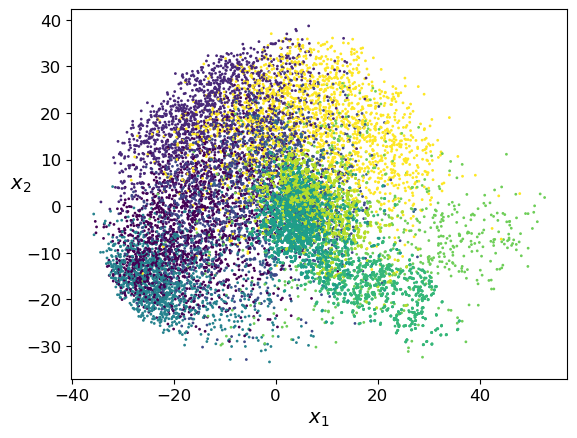

In [35]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10)
gmm.fit(X_pca)

labels = gmm.predict(X_pca)

plot_clusters(X_pca, labels)


In [36]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(X_pca, labels)
print("Silhouette Score = ", silhouette_scores)

Silhouette Score =  0.06831429983848246


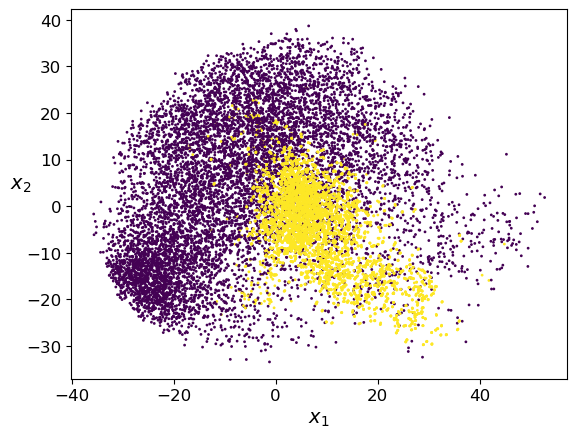

In [37]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2)
gmm.fit(X_pca)

labels_2 = gmm.predict(X_pca)

plot_clusters(X_pca, labels_2)

In [38]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(X_pca, labels_2)
print("Silhouette Score = ", silhouette_scores)

Silhouette Score =  0.07732882722621773


Silhouette Score with t-SNE + GMM =  0.33877763


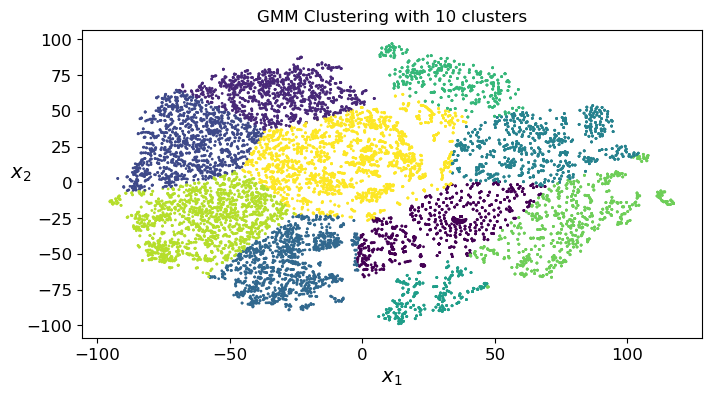

In [39]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train_scaled)

# Now apply K-means clustering on the t-SNE processed data
gmm = GaussianMixture(n_components=10)
gmm_labels_tsne = gmm.fit_predict(x_train_tsne)

silhouette_scores_tsne = silhouette_score(x_train_tsne, gmm_labels_tsne)
print("Silhouette Score with t-SNE + GMM = ", silhouette_scores_tsne)

plt.figure(figsize=(8, 4))
plt.title("GMM Clustering with 10 clusters")
plot_clusters(x_train_tsne, gmm_labels_tsne)
plt.show()

Silhouette Score with t-SNE + GMM =  0.38197315


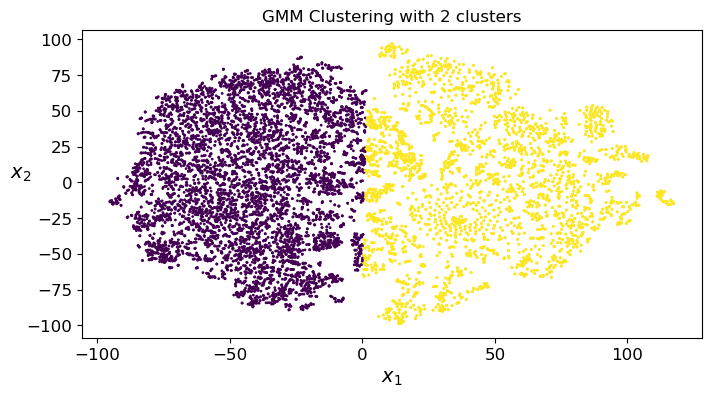

In [40]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train_scaled)

# Now apply K-means clustering on the t-SNE processed data
gmm = GaussianMixture(n_components=2)
gmm_labels_tsne = gmm.fit_predict(x_train_tsne)

silhouette_scores_tsne = silhouette_score(x_train_tsne, gmm_labels_tsne)
print("Silhouette Score with t-SNE + GMM = ", silhouette_scores_tsne)

plt.figure(figsize=(8, 4))
plt.title("GMM Clustering with 2 clusters")
plot_clusters(x_train_tsne, gmm_labels_tsne)
plt.show()

# EXTRA STUFF

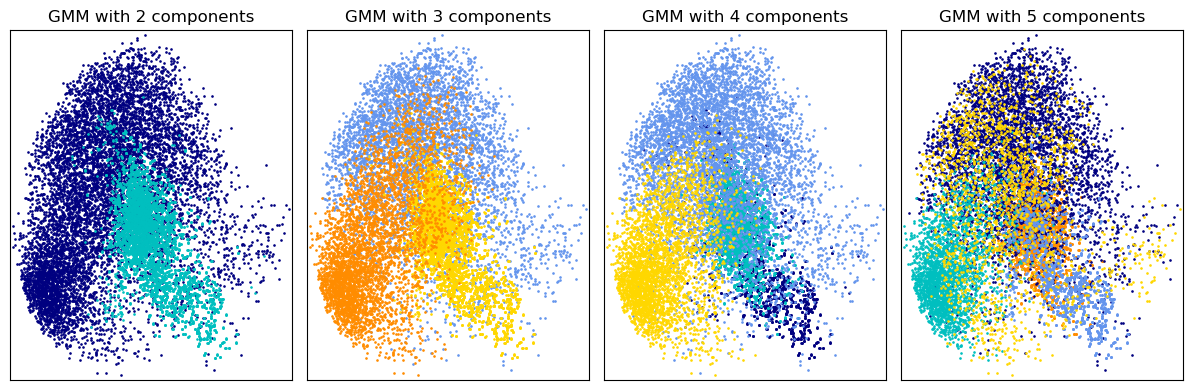

In [41]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from sklearn import mixture

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(1, 5, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])

        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi
        ell = plt.matplotlib.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

fig = plt.figure(figsize=(15, 4)) 

for i in range(2, 6): 
    gmm = mixture.GaussianMixture(n_components=i, covariance_type="full").fit(X_pca)
    plot_results(X_pca, gmm.predict(X_pca), gmm.means_, gmm.covariances_, i - 1, f"GMM with {i} components")

plt.tight_layout()
plt.show()

Silhouette Score with t-SNE + GMM with 2 components =  0.38201928
Silhouette Score with t-SNE + GMM with 3 components =  0.39917734
Silhouette Score with t-SNE + GMM with 4 components =  0.36344695
Silhouette Score with t-SNE + GMM with 5 components =  0.3545756
Silhouette Score with t-SNE + GMM with 6 components =  0.37134373
Silhouette Score with t-SNE + GMM with 7 components =  0.33223578
Silhouette Score with t-SNE + GMM with 8 components =  0.3498881
Silhouette Score with t-SNE + GMM with 9 components =  0.3212084
Silhouette Score with t-SNE + GMM with 10 components =  0.3568091


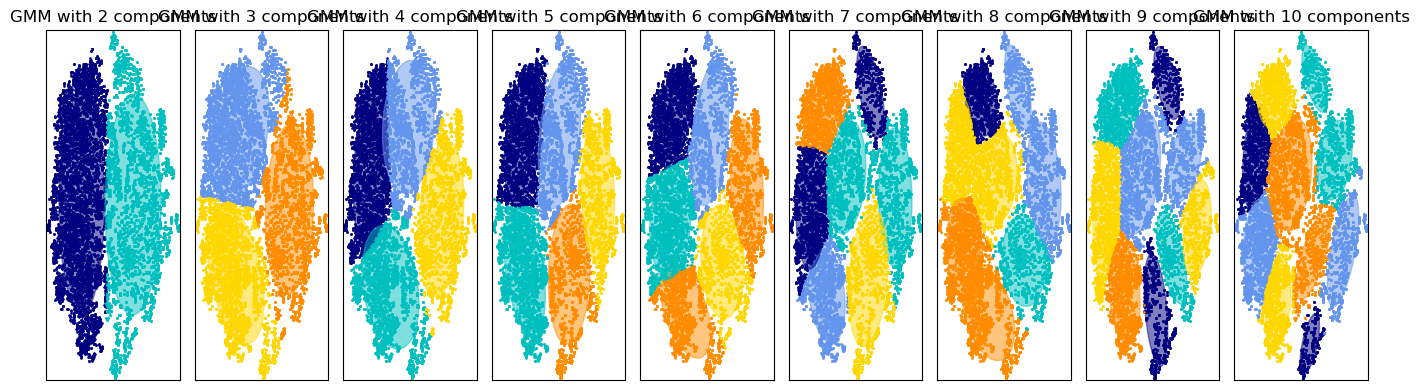

In [42]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from sklearn import mixture

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(1, 10, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])

        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi
        ell = plt.matplotlib.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

fig = plt.figure(figsize=(15, 4)) 

for i in range(2, 11): 
    gmm = mixture.GaussianMixture(n_components=i, covariance_type="full").fit(x_train_tsne)
    plot_results(x_train_tsne, gmm.predict(x_train_tsne), gmm.means_, gmm.covariances_, i - 1, f"GMM with {i} components")
    gmm_labels_tsne = gmm.fit_predict(x_train_tsne)
    silhouette_scores_tsne = silhouette_score(x_train_tsne, gmm_labels_tsne)
    print(f"Silhouette Score with t-SNE + GMM with {i} components = ", silhouette_scores_tsne)

plt.tight_layout()
plt.show()

Silhouette Score with t-SNE + GMM with 2 components =  0.37441516
Silhouette Score with t-SNE + GMM with 3 components =  0.3247472
Silhouette Score with t-SNE + GMM with 4 components =  0.33012855
Silhouette Score with t-SNE + GMM with 5 components =  0.31661808
Silhouette Score with t-SNE + GMM with 6 components =  0.3145157
Silhouette Score with t-SNE + GMM with 7 components =  0.32351482
Silhouette Score with t-SNE + GMM with 8 components =  0.3349911
Silhouette Score with t-SNE + GMM with 9 components =  0.3120453
Silhouette Score with t-SNE + GMM with 10 components =  0.31194657


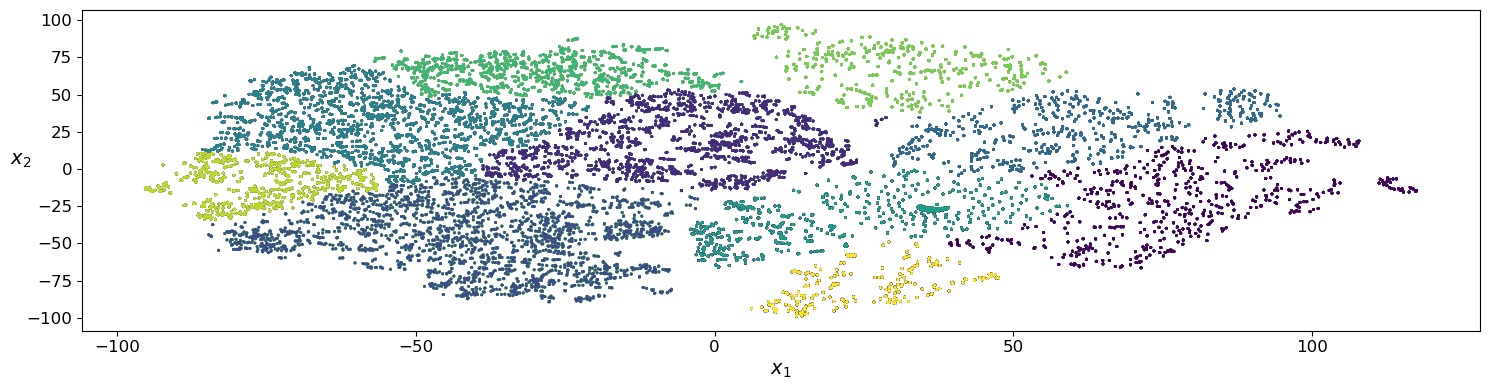

In [43]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from sklearn import mixture

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(1, 10, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])

        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi
        ell = plt.matplotlib.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

fig = plt.figure(figsize=(15, 4)) 

for i in range(2, 11): 
    agg = AgglomerativeClustering(n_clusters=i).fit(x_train_tsne)
    agg_labels_tsne = agg.fit_predict(x_train_tsne)
    plot_clusters(x_train_tsne, agg_labels_tsne)
    silhouette_scores_tsne = silhouette_score(x_train_tsne, agg_labels_tsne)
    print(f"Silhouette Score with t-SNE + GMM with {i} components = ", silhouette_scores_tsne)

plt.tight_layout()
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.38200572
For n_clusters = 3 The average silhouette_score is : 0.39922717
For n_clusters = 4 The average silhouette_score is : 0.36346737
For n_clusters = 5 The average silhouette_score is : 0.35413405
For n_clusters = 6 The average silhouette_score is : 0.37026715


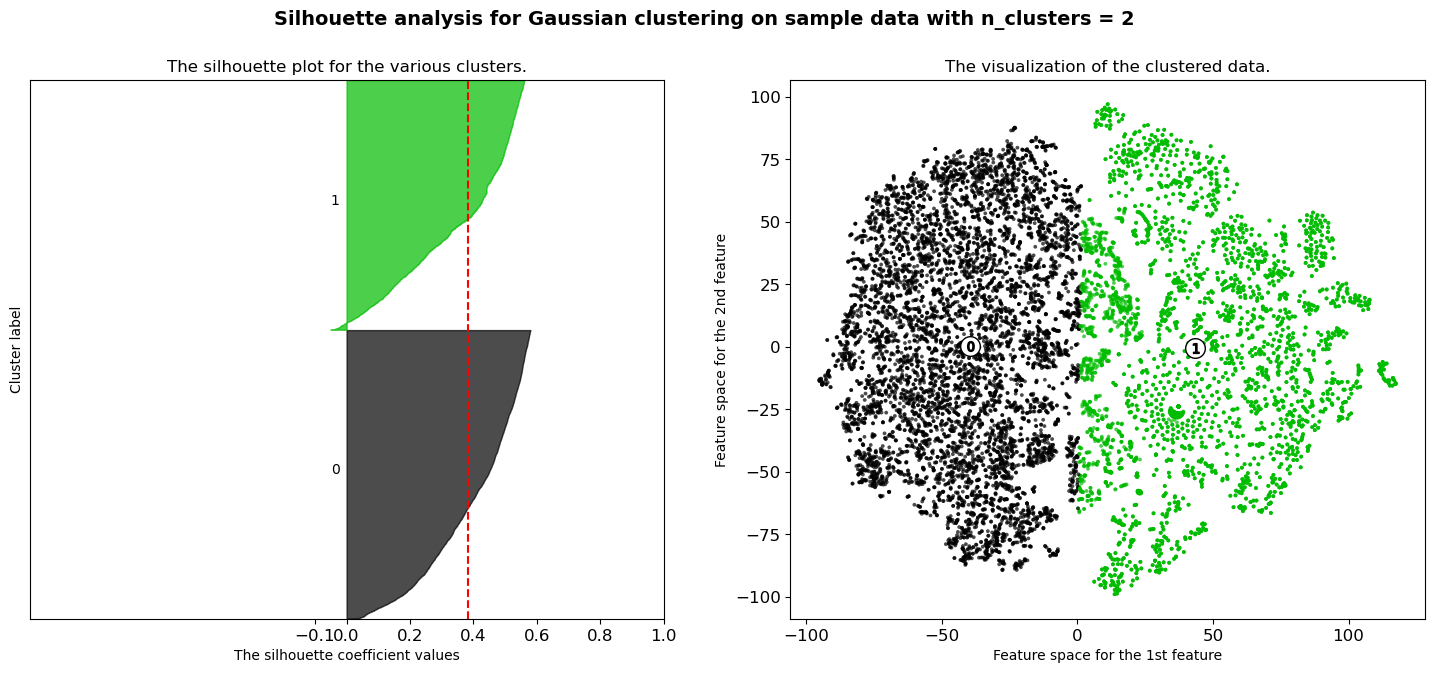

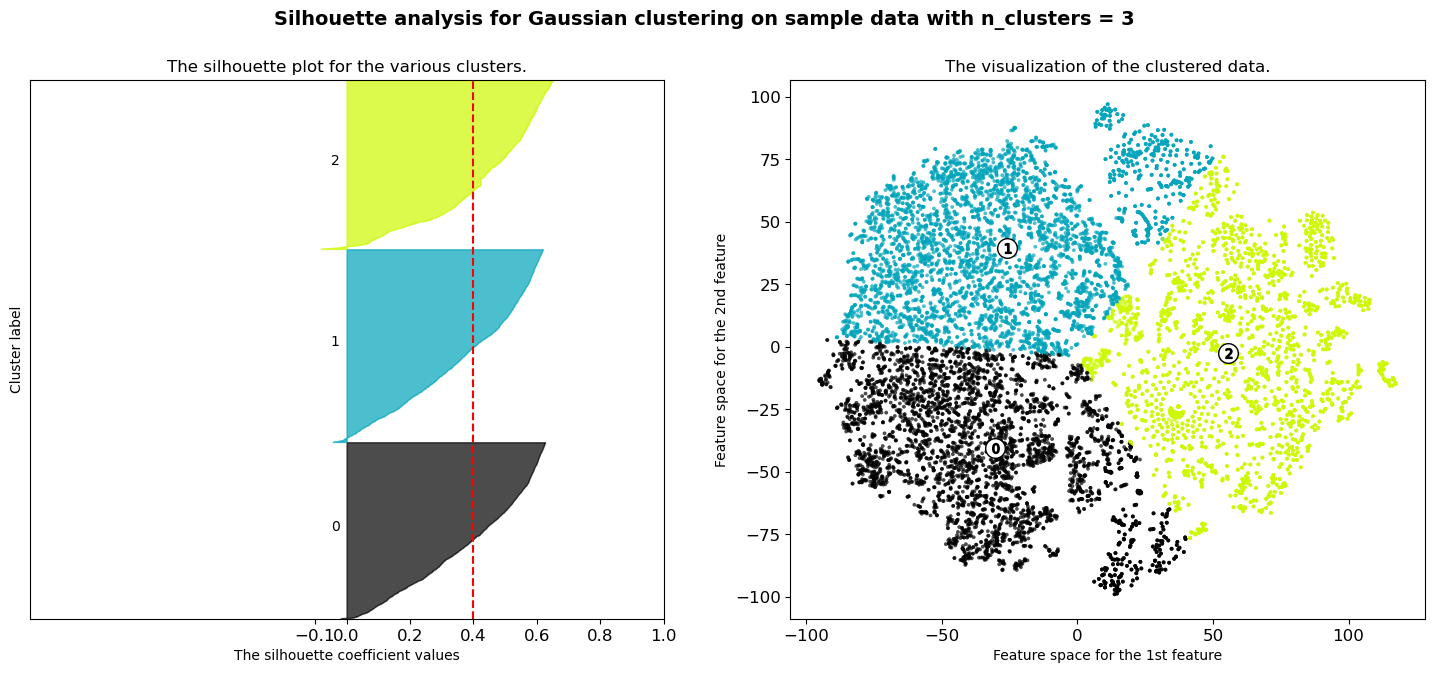

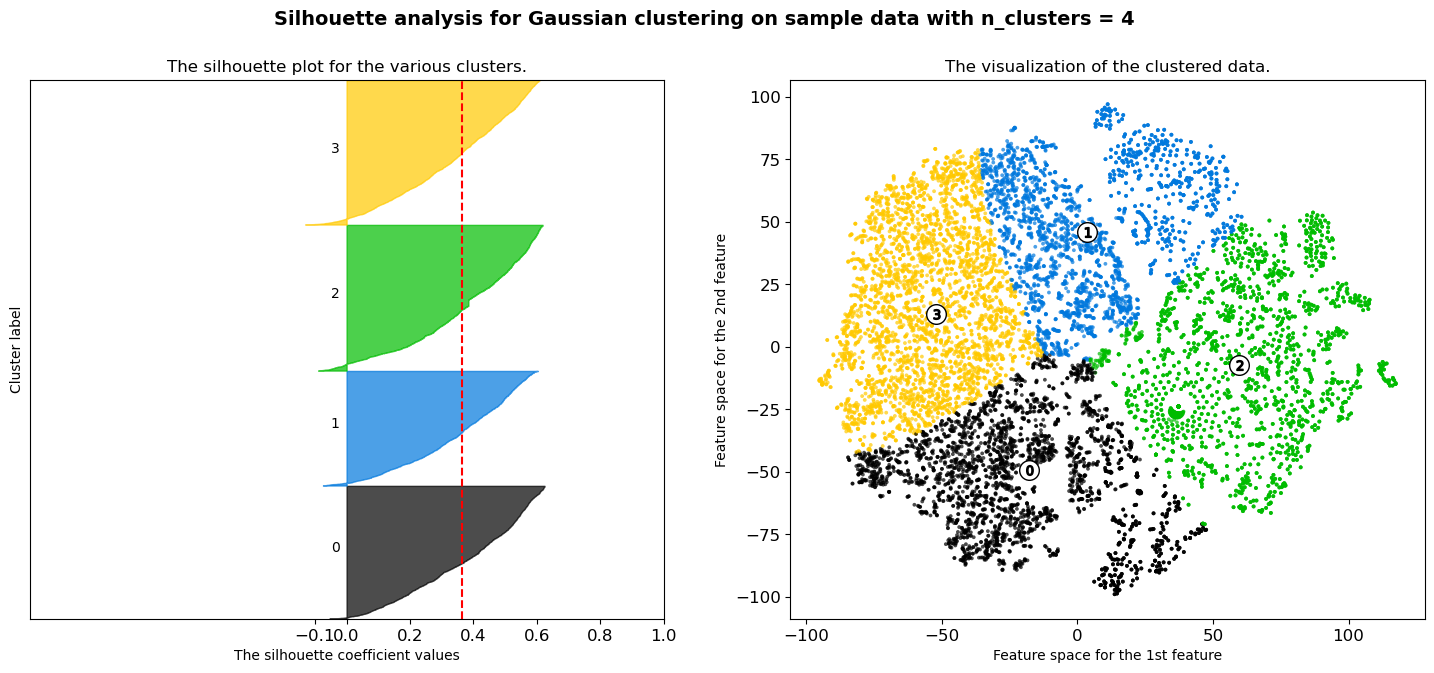

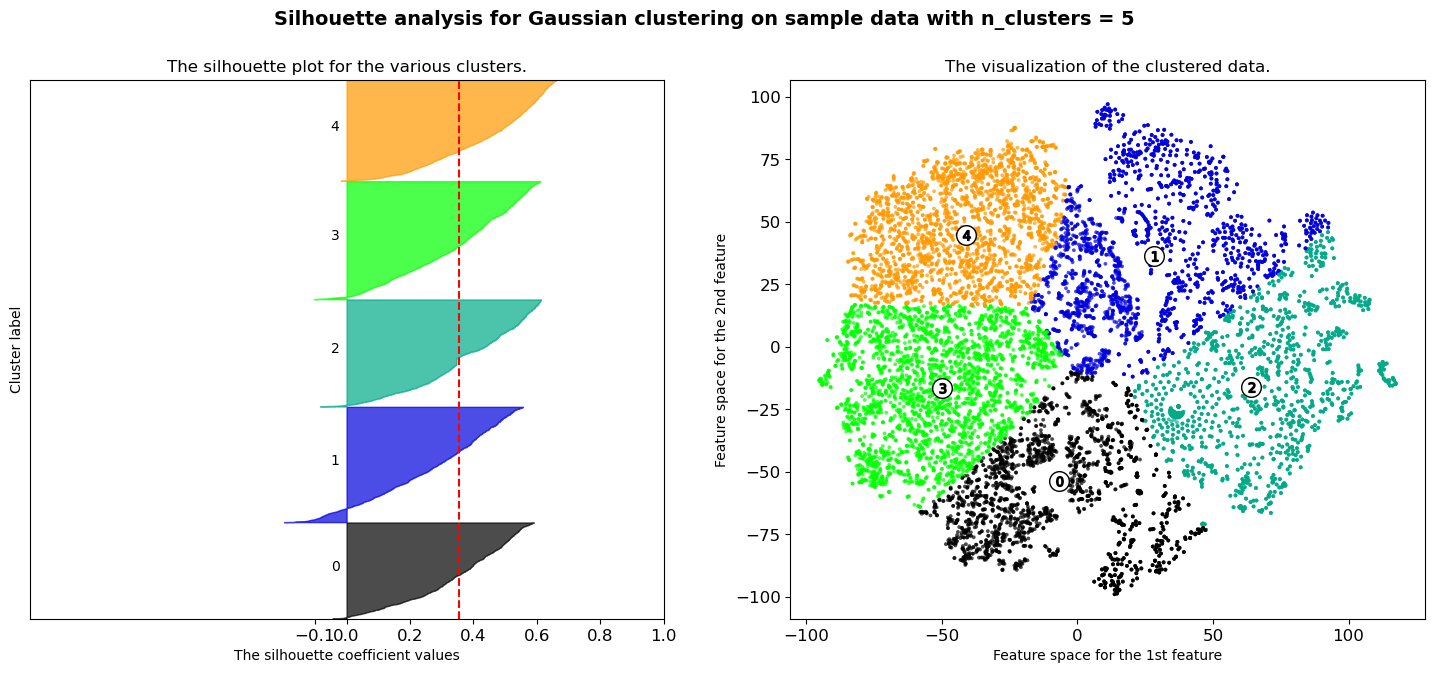

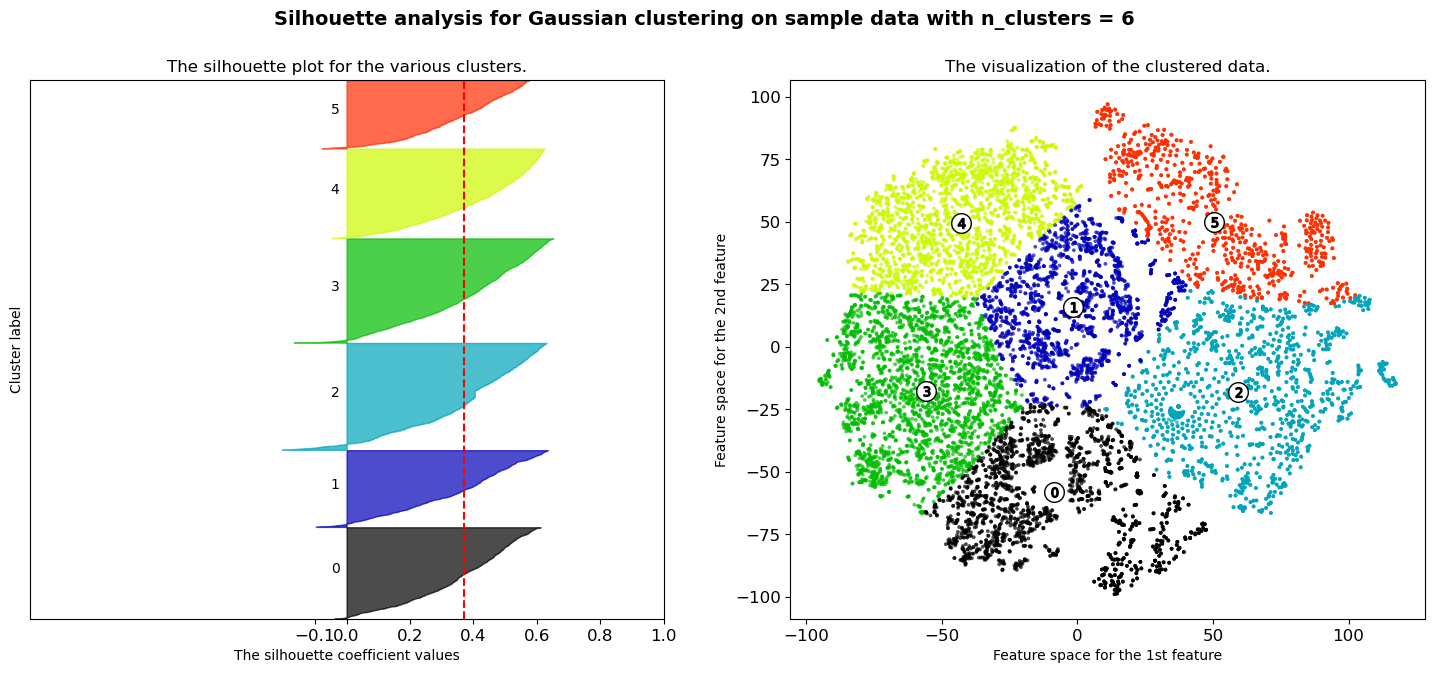

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_train) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = GaussianMixture(n_components=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_train_tsne)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_train_tsne, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_train_tsne, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(x_train_tsne[:, 0], x_train_tsne[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    
    centers = clusterer.means_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for Gaussian clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()